# Corpus 전처리

현재 데이터는 xlsx로 저장이 되어 있다. <br/><br/>COCA 코퍼스와 같은 영어 corpus와 비교 예정이기에 전처리가 필요한데, 이를 위해 데이터 저장 포멧은 크게 3가지가 있고 아래와 같다. <br/> <br/> <br/> 1. csv: 엑셀로 읽을 수 있으며 가독성이 좋다. 테이블 형식의 데이터 정리에 유용. <br/> 2. parquet: 하둡과 같은 프레임 워크를 위해 개발된 데이터 압축 형태이고, 압축이 가장 잘되는 열 방향 데이터 정보 포멧. <br/> 3. json: 일반적으로 CS 분야에서 통신이나 테이블 형태가 아닌 데이터 저장에 많이 사용되는 형태. 압축률이 좋지는 않으나 유연한 구조로 인해 확장이 쉽다.<br/><br/> <br/> 고로 이번에는 json으로 사용하려고 한다.

## 개발 환경 세팅

python을 언어로 사용할 거고, uv를 사용해 필요한 라이브러리를 다운로드할 것이다. 
<br/> uv 란? -> python 라이브러리를 굉장히 빨리 다운로드해주는 pkg-manager
<br/> 혹시라도 읽고 계신 분이 CS 분야 전공자라면, 부디 쓰시길 바랍니다. conda, pip 대비 비교도 안될 정도로 빠릅니다,,

만약 github에서 pull하고 사용 중이라면 pyproject.toml 파일을 열어보면 dependencies에서 라이브러리 이름을 확인할 수 있을 텐데 그게 꼭 설치되어야 아래가 진행 가능하다!!!

## 데이터 전처리 전략 및 순서

전처리 순서는 아래와 같다.<br/><br/><br/> 1. 문잔 단위 분할 <br/> 2. 단어 단위 분할 및 품사 태깅

### 문장 기준 분할

수능 영어 듣기 corpus: csat_listening_article

### 라이브러리 import

In [1]:
import nltk # Natural Language Toolkit
from nltk import word_tokenize, pos_tag, sent_tokenize # Natural Language Toolkit
from nltk.tokenize import WhitespaceTokenizer
#import contractions # 영어 줄임말 풀기 -> 축약형은 풀지 않기로,,
import pandas as pd # 데이터 처리
import numpy as np # 데이터 처리
import seaborn as sns # 데이터 시각화
from tqdm import tqdm # 데이터 처리
import re # 정규식으로 특수기호 및 char 처리
import json # 데이터 가공 후 저장할 형식
from typing import Any, Dict, List  # python data-type 정의
from pathlib import Path # 파일 경로 처리
import os # 파일 경로 및 처리
from sklearn.preprocessing import StandardScaler # 전처리 시 normalize
from customTokenizer import CustomTokenizer
from preprocessor import Preprocessor, TargetCorpusPreprocessor
from json_handler import JsonFileHandler

In [2]:
# 사용 예시
def test_configurable_tokenizer():

    # 축약형과 소유격 보존 + 토큰 필터링
    tokenizer = CustomTokenizer(
        preserve_contractions=True,
        preserve_possessives=True,
        preserve_numbers=False,
        preserve_urls=False,
        preserve_emails=False,
        filter_tokens=True
    )
    
    
    test_text = "I'm going to John's house at 3:30 PM. Email me at test@example.com or visit https://example.com. How are you?"

    print("\n모든 패턴 보존 + 토큰 필터링:")
    print(f"before: {test_text}")
    tokens = tokenizer.tokenize(test_text)
    print(f"after: {tokens}")

test_configurable_tokenizer()


모든 패턴 보존 + 토큰 필터링:
before: I'm going to John's house at 3:30 PM. Email me at test@example.com or visit https://example.com. How are you?
after: ["I'm", 'going', 'to', "John's", 'house', 'at', 'PM', '.', 'Email', 'me', 'at', 'test', 'example', '.', 'com', 'or', 'visit', 'https', 'example', '.', 'com', '.', 'How', 'are', 'you', '?']


In [3]:
# tokenizer comparison
test_text = "I'm going to John's house at 3:30 PM. Email me at test@example.com or visit https://example.com. How are you?"
nltk.word_tokenize(test_text),WhitespaceTokenizer().tokenize(test_text)

(['I',
  "'m",
  'going',
  'to',
  'John',
  "'s",
  'house',
  'at',
  '3:30',
  'PM',
  '.',
  'Email',
  'me',
  'at',
  'test',
  '@',
  'example.com',
  'or',
  'visit',
  'https',
  ':',
  '//example.com',
  '.',
  'How',
  'are',
  'you',
  '?'],
 ["I'm",
  'going',
  'to',
  "John's",
  'house',
  'at',
  '3:30',
  'PM.',
  'Email',
  'me',
  'at',
  'test@example.com',
  'or',
  'visit',
  'https://example.com.',
  'How',
  'are',
  'you?'])

## preprocessor class

In [93]:
# sample
preprocessor = Preprocessor(type='test', tokenizer_type='custom') # tokenize
text = "I'm going to John's house at 3:30 PM. Email me at test@example.com or visit https://example.com. How are you?"

sentences = preprocessor.split_sentences(text)
for sentence in sentences:
    #print(preprocessor.tokenize_sentence(sentence))
    print(preprocessor.split_word_pos(preprocessor.tokenize_sentence(sentence)))

(["I'm", 'going', 'to', "John's", 'house', 'at', 'PM', '.'], ['NNP', 'VBG', 'TO', 'NNP', 'NN', 'IN', 'NNP', '.'])
(['Email', 'me', 'at', 'test', 'example', '.', 'com', 'or', 'visit', 'https', 'example', '.', 'com', '.'], ['VB', 'PRP', 'IN', 'NN', 'NN', '.', 'NN', 'CC', 'NN', 'JJ', 'NN', '.', 'NN', '.'])
(['How', 'are', 'you', '?'], ['WRB', 'VBP', 'PRP', '.'])


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


예상하는 json 데이터 구조
<br>
~~~json
{
  "text": "원본 텍스트",
  "tokens": ["토큰1", "토큰2"],
  "pos_tags": ["NN", "VB"],
  "metadata": {
    "source": "수능",
    "year": "2023",
    "month": "6",
    "note": ".",
    "gender": "M",
    "type": "listening"
  }
}
~~~

## 수능 Corpus 전처리

In [28]:
# 파일 경로 확인.
proj_path = os.path.dirname(os.path.dirname(Path.cwd()))
corpora_dir = os.path.join(proj_path, 'Corpora')
listening_article_path = os.path.join(corpora_dir, 'CSAT_raw', 'csat_listening_article.xlsx')
reading_article_path = os.path.join(corpora_dir, 'CSAT_raw', 'csat_reading_article.xlsx')
textbook_article_path = os.path.join(corpora_dir, 'CSAT_raw', 'english_textbook_article.xlsx')

# 파일 경로 유효성 확인.
if not os.path.exists(listening_article_path):
    raise FileNotFoundError(f"Listening article file not found at {listening_article_path}")
if not os.path.exists(reading_article_path):
    raise FileNotFoundError(f"Reading article file not found at {reading_article_path}")
if not os.path.exists(textbook_article_path):
    raise FileNotFoundError(f"Textbook article file not found at {textbook_article_path}")
print("All file paths are valid.")


All file paths are valid.


In [16]:
# 영어 듣기 지문 읽어오기
listening_article = pd.read_excel(listening_article_path)
listening_article

,년도,월,번호,출처,본문,비고
0,2016.0,11,1.0,수능,"W: Charlie, where did you get these apples? Th...",.
1,NaN,NaN,2.0,NaN,M: Excuse me. I see the 2 o’clock flight to Da...,.
2,NaN,NaN,3.0,NaN,"W: Hello, listeners! This is One Minute Health...",.
3,NaN,NaN,4.0,NaN,"M: Ms. Robinson, what was your opinion of Mr. ...",.
4,NaN,NaN,5.0,NaN,"W: How was everything, Mr. Silverman? \nM: Goo...",.
...,...,...,...,...,...,...
1302,NaN,NaN,13.0,NaN,① W: What can I do for you today?\nM: I'd like...,그림의 상황에 적절한 대화를 고르는 문제 / 답 4
1303,NaN,NaN,14.0,NaN,W: You must be my new next door neighbor. Welc...,NaN
1304,NaN,NaN,15.0,NaN,"W: Hey, Joe. How are you doing?\nM: Hi, Michel...",NaN
1305,NaN,NaN,16.0,NaN,"W: Peter, how's the planning for the school fe...",NaN


In [17]:
# 전체 행은 1307, 본문이 있는 행은 1234 -> 본문이 있는 행만 기준으로 처리
listening_article.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307 entries, 0 to 1306
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   년도      77 non-null     float64
 1   월       77 non-null     object 
 2   번호      1306 non-null   float64
 3   출처      77 non-null     object 
 4   본문      1234 non-null   object 
 5   비고      1291 non-null   object 
dtypes: float64(2), object(4)
memory usage: 61.4+ KB


In [18]:
# 결측치 제거 후 불필요 행 지우기
preprocessor = Preprocessor(type='test', tokenizer_type='custom') # tokenize
listening_article = preprocessor.fillter_values(listening_article).dropna(how='any')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
데이터 형식 통일 중..: 100%|██████████| 1307/1307 [00:00<00:00, 2883.25it/s]


In [20]:
listening_article

,년도,월,번호,출처,본문,비고
0,2016.0,11,1.0,수능,"W: Charlie, where did you get these apples? Th...",.
1,2016.0,11,2.0,수능,M: Excuse me. I see the 2 o’clock flight to Da...,.
2,2016.0,11,3.0,수능,"W: Hello, listeners! This is One Minute Health...",.
3,2016.0,11,4.0,수능,"M: Ms. Robinson, what was your opinion of Mr. ...",.
4,2016.0,11,5.0,수능,"W: How was everything, Mr. Silverman? \nM: Goo...",.
...,...,...,...,...,...,...
1286,1999.0,11,14.0,수능,"Woman: Hi, John. How are you? \nMan : Not very...",.
1287,1999.0,11,15.0,수능,"Man : Hi, Su-mi, congratulations! I heard on t...",.
1288,1999.0,11,16.0,수능,"Today, Id like to talk about the future of edu...",.
1289,1999.0,11,17.0,수능,Man : Suppose you are leaving on a long trip t...,.


In [21]:
listening_article = preprocessor.change_data_type(listening_article)

/var/folders/3t/7cyq0j713bn7qcyfypl8dx3w0000gn/T/ipykernel_83831/1232950257.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['년도'] = corpus['년도'].astype('int')
/var/folders/3t/7cyq0j713bn7qcyfypl8dx3w0000gn/T/ipykernel_83831/1232950257.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['월'] = corpus['월'].astype('int')
/var/folders/3t/7cyq0j713bn7qcyfypl8dx3w0000gn/T/ipykernel_83831/1232950257.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [22]:
listening_article.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1218 entries, 0 to 1302
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   년도      1218 non-null   object
 1   월       1218 non-null   object
 2   번호      1218 non-null   object
 3   출처      1218 non-null   object
 4   본문      1218 non-null   object
 5   비고      1218 non-null   object
dtypes: object(6)
memory usage: 66.6+ KB


In [528]:
print(listening_article['출처'].unique())
print(listening_article['년도'].unique())
print(listening_article['월'].unique())
print(listening_article['번호'].unique())
print(listening_article['비고'].unique())

['수능' '모의']
['2016' '2017' '2018' '2019' '2020' '2021' '2022' '2023' '2024' '2015'
 '2025' '2014' '2013' '2012' '2011' '2010' '2009' '2008' '2007' '2006'
 '2005' '2004' '2003' '2002' '2001' '2000' '1999']
['11' '12' '6' '9']
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21']
['.' '그림의 상황에 적절한 대화를 고르는 문제 / 답 4' '그림의 상황에 적절한 대화를 고르는 문제 / 답 3'
 '그림의 상황에 적절한 대화를 고르는 문제 / 답 5' '그림의 상황에 적절한 대화를 고르는 문제 / 답 1'
 '그림의 상황에 적절한 대화를 고르는 문제 / 답 2' 'A5' 'A7' 'A16' 'A17' 'A19' 'A20']


병렬 처리 참고: https://yganalyst.github.io/data_handling/memo_17_parallel/


In [57]:
def preprocess_article(corpus: pd.DataFrame, corpus_type: str, preprocessor: Preprocessor, json_handler: JsonFileHandler, save_path: str):
    
    if not os.path.exists(save_path):
        raise FileNotFoundError(f"Save path not found at {save_path}")

    allowed_expression = r"[^a-zA-Z,.']" # 허용된 문자열 패턴

    if 'test' in corpus_type: # 수능 corpus
        for idx, row in tqdm(corpus.iterrows(), desc='separating sentences..', total=len(corpus)):
            sentences = preprocessor.split_sentences(row['본문'])
            
            before_gender = 'N' # 초기 화자의 성별 초기화
            for sentence in sentences:  # 문장 더미에서 하나의 문장을 가져와서
                
                current_gender = preprocessor.get_gender(sentence)   # 문장 내 화자 성별 정보 추출
                if current_gender == 'N':   # 만약 문장 내에서 확인이 되지 않는다면,
                    current_gender = before_gender # 이전 화자의 성별 유지
                else:   # 문장 내에세 화자 성별이 포착되었다면,
                    before_gender = current_gender # 다음 문장을 위해 성별 정보 업데이트
                
                if current_gender != 'N':
                    sentence = sentence.replace(current_gender+':', '') # 원 문장에서 성별 정보 제거
                    sentence = sentence.replace(current_gender+' ', '') # 원 문장에서 성별 정보 제거

                cleaned_sentence = sentence.lower()
                #cleaned_sentence = contractions.fix(cleaned_sentence) 축약형 풀지 않는 것으로 변경
                cleaned_sentence = re.sub(allowed_expression, ' ', cleaned_sentence) # 여러 spacebar가 포함되지만, tokenize에서 정리됨. 영어, 콤마, 온점, 퍼센트만 유지
                
                tokenized = preprocessor.tokenize_sentence(cleaned_sentence) # 문장 -> 어절 분리
                word_list, pos_list = preprocessor.split_word_pos(tokenized) # 어절 -> 단어 및 품사 분리

                metadata = {
                    "source": row['출처'],
                    "year": row['년도'],
                    "month": row['월'],
                    "note": row['비고'],
                    "gender": current_gender,
                    "type": corpus_type
                }
                
                json_data = preprocessor.generate_json_data(id = idx, text=sentence, tokens=word_list, pos_tags=pos_list, metadata=metadata)
                json_file_name = f"{corpus_type}_article_{row['년도']}_{row['출처']}.json"
                json_file_path = os.path.join(save_path, json_file_name)
                json_handler.update_json_file(json_file_path, json_data)
    
    elif corpus_type == 'textbook':
        for idx, row in tqdm(corpus.iterrows(), desc='separating sentences..', total=len(corpus)):
            sentences = preprocessor.split_sentences(row['본문'])

            for sentence in sentences:  # 문장 더미에서 하나의 문장을 가져와서
                cleaned_sentence = sentence.lower()
                #cleaned_sentence = contractions.fix(cleaned_sentence)
                cleaned_sentence = re.sub(allowed_expression, ' ', cleaned_sentence) # 여러 spacebar가 포함되지만, tokenize에서 정리됨. 영어, 콤마, 온점, 퍼센트만 유지
                
                tokenized = preprocessor.tokenize_sentence(cleaned_sentence) # 문장 -> 어절 분리
                word_list, pos_list = preprocessor.split_word_pos(tokenized) # 어절 -> 단어 및 품사 분리

                metadata = {
                    "source": row['출처'],
                    "note": row['비고'],
                    "type": corpus_type
                }
                
                json_data = preprocessor.generate_json_data(id = idx, text=sentence, tokens=word_list, pos_tags=pos_list, metadata=metadata)
                json_file_name = f"{corpus_type}_article_{row['출처']}.json"
                json_file_path = os.path.join(save_path, json_file_name)
                json_handler.update_json_file(json_file_path, json_data)
    else:
        raise ValueError(f"Invalid corpus type: {corpus_type}")


### 바로 실행,,

In [36]:
save_path = os.path.join(corpora_dir, 'CSAT-latest')
save_path

'/Users/bagjuhyeon/Documents/WorkSpace/corpus-comparison/Corpora/CSAT-latest'

In [37]:
preprocessor = Preprocessor(type='test', tokenizer_type='custom')
json_handler = JsonFileHandler()

# 영어 듣기 지문 읽어오기
listening_article = pd.read_excel(listening_article_path)
listening_article = preprocessor.fillter_values(listening_article).dropna(how='any')
listening_article = preprocessor.change_data_type(listening_article)
preprocess_article(corpus=listening_article, corpus_type='test_listening', preprocessor=preprocessor, json_handler=json_handler, save_path=save_path)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
separating sentences..: 100%|██████████| 1218/1218 [00:14<00:00, 81.38it/s] 


### 읽기 지문도 동일하게 처리

In [38]:
# 영어 듣기 지문 읽어오기
reading_article = pd.read_excel(reading_article_path)
reading_article = preprocessor.fillter_values(reading_article).dropna(how='any')
reading_article = preprocessor.change_data_type(reading_article)
preprocess_article(corpus=reading_article, corpus_type='test_reading', preprocessor=preprocessor, json_handler=json_handler, save_path=save_path)

separating sentences..: 100%|██████████| 2168/2168 [00:23<00:00, 90.86it/s] 


## 영어 교과서 Corpus 전처리

예상하는 json 데이터 구조
<br>
~~~json
{
  "text": "원본 텍스트",
  "tokens": ["토큰1", "토큰2"],
  "pos_tags": ["NN", "VB"],
  "metadata": {
    "source": "수능",
    "year": "2023",
    "month": "6",
    "note": ".",
    "gender": "M",
    "type": "listening"
  }
}
~~~

In [55]:
textbook_article = pd.read_excel(textbook_article_path)
textbook_article.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   출판사     698 non-null    object
 1   저자      698 non-null    object
 2   과정      698 non-null    object
 3   교과서     698 non-null    object
 4   단원      698 non-null    object
 5   단원명     695 non-null    object
 6   본문제목    643 non-null    object
 7   본문      644 non-null    object
 8   비고      698 non-null    object
dtypes: object(9)
memory usage: 49.2+ KB


In [46]:
save_path

'/Users/bagjuhyeon/Documents/WorkSpace/corpus-comparison/Corpora/CSAT-latest'

In [ ]:
preprocessor = Preprocessor(type='textbook', tokenizer_type='custom')
json_handler = JsonFileHandler()
textbook_article = preprocessor.fillter_values(textbook_article).dropna(how='any')
textbook_article = preprocessor.change_data_type(textbook_article)
preprocess_article(corpus=textbook_article, corpus_type='textbook', preprocessor=preprocessor, json_handler=json_handler, save_path=save_path)

# Corpus 분석

## 수능 및 모의고사 지문 분석

In [65]:
json_handler = JsonFileHandler()
CSAT_path = os.path.join(corpora_dir, 'CSAT-latest')
corpus_list = os.listdir(CSAT_path)
corpus_list = [file for file in corpus_list if file.endswith('.json')]
reading_corpus = [file for file in corpus_list if 'reading' in file]
listening_corpus = [file for file in corpus_list if 'listening' in file]
textbook_corpus = [file for file in corpus_list if 'textbook' in file]

len(reading_corpus), len(listening_corpus), len(textbook_corpus)

(52, 49, 71)

In [66]:
def plot_pos_tag(corpus: list):
    # 읽기 지문 품사 분석
    pos_list = []   # 품사 정보를 담을 리스트

    for document in corpus: # corpus에서 하나의 json 파일을 가져와서
        document = json_handler.load_data(os.path.join(CSAT_path, document))  # 하나의 json 파일 내에 있는 모든 파일을 가져옴.

        if isinstance(document, list):   # 한 json 내에 여러 obj가 있는 경우, 
            for sentence in document:  # json 파일 내 있는 여러 문장들 수 
                pos_list.extend(sentence['pos_tags'])
        else:   # 한 json 내에 하나의 obj가 있는 경우, 
            pos_list.extend(document['pos_tags'])   

    len(pos_list)
    pos_list = pd.Series(pos_list)
    sns.countplot(data = pos_list, order=pos_list.value_counts().index)
    return pos_list.to_list()

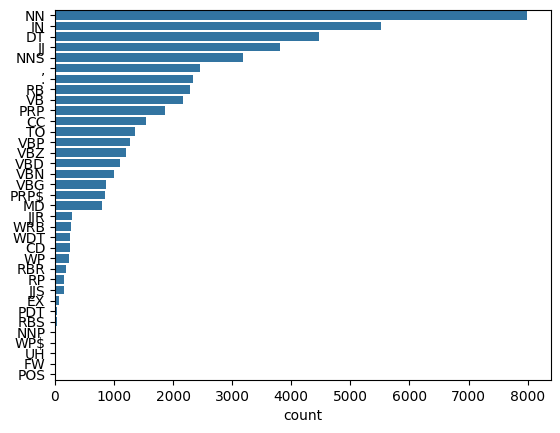

In [67]:
reading_pos_list = plot_pos_tag(reading_corpus)

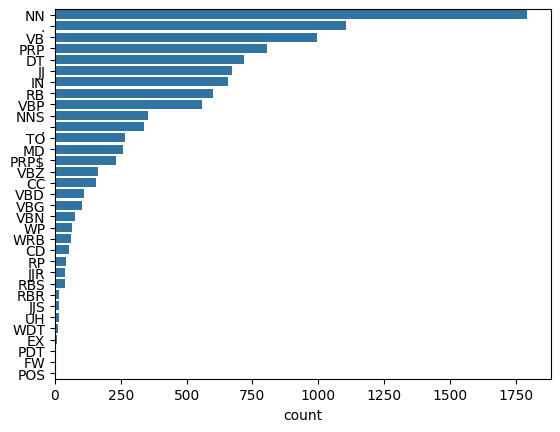

In [68]:
listening_pos_list = plot_pos_tag(listening_corpus)

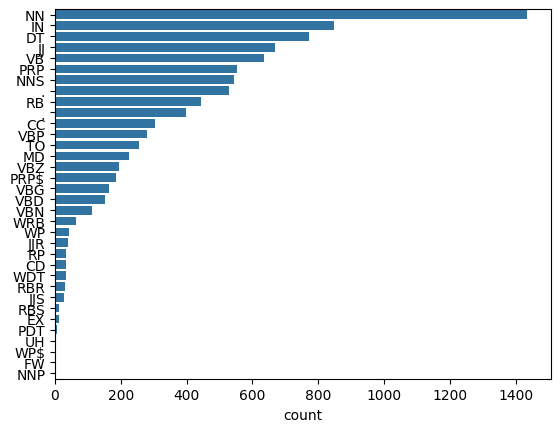

In [70]:
textbook_pos_list = plot_pos_tag(textbook_corpus)

<Axes: xlabel='count'>

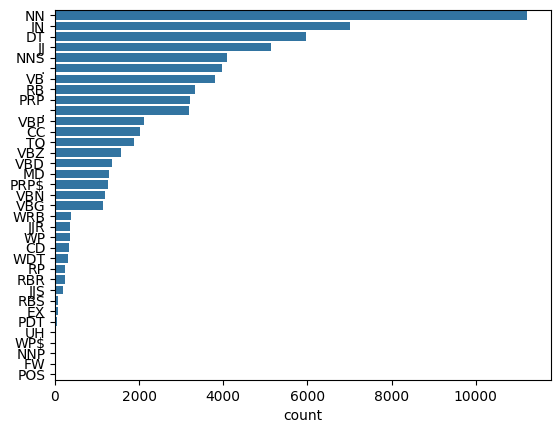

In [71]:
corpus_pos_list = pd.Series(listening_pos_list + reading_pos_list + textbook_pos_list)
sns.countplot(data = corpus_pos_list, order=corpus_pos_list.value_counts().index)

In [79]:
csat_word_list_df = csat_word_list.value_counts().to_frame().reset_index().rename(columns={'index': 'word', 'count': 'CSAT_Freq'})
textbook_word_list_df = textbook_word_list.value_counts().to_frame().reset_index().rename(columns={'index': 'word', 'count': 'Textbook_Freq'})
csat_vs_textbook_df = csat_word_list_df.merge(textbook_word_list_df, on='word', how='outer')
csat_vs_textbook_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7796 entries, 0 to 7795
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   word           7796 non-null   object 
 1   CSAT_Freq      7282 non-null   float64
 2   Textbook_Freq  2076 non-null   float64
dtypes: float64(2), object(1)
memory usage: 182.8+ KB


In [80]:
csat_vs_textbook_df.dropna(inplace=True)
#csat_vs_textbook_df.to_csv('./corpus/csat_vs_textbook_df.csv', index=False)

아래에서는 단순히 CSAT, textbook만 합쳤는데, HAL이나 SUBTLEX랑도 여기서 다시 합쳐서 POS 기준으로 존재하지 않는 단어 뺄 필요가 있겠네,,

In [83]:
csat_vs_textbook_df['Log_CSAT_Freq'] = np.log1p(csat_vs_textbook_df['CSAT_Freq'])
csat_vs_textbook_df['Log_Textbook_Freq'] = np.log1p(csat_vs_textbook_df['Textbook_Freq'])
csat_vs_textbook_df.to_excel(os.path.join(proj_path,'Corpora', 'merged_corpora', 'csat_vs_textbook_df.xlsx'), index=False)
csat_vs_textbook_df

,word,CSAT_Freq,Textbook_Freq,Log_CSAT_Freq,Log_Textbook_Freq
6,",",2787.0,398.0,7.933080,5.988961
7,.,3435.0,530.0,8.142063,6.274762
8,a,1098.0,186.0,7.002156,5.231109
12,able,21.0,8.0,3.091042,2.197225
16,about,136.0,28.0,4.919981,3.367296
...,...,...,...,...,...
7768,you,650.0,163.0,6.478510,5.099866
7772,young,19.0,2.0,2.995732,1.098612
7773,younger,4.0,1.0,1.609438,0.693147
7776,your,284.0,60.0,5.652489,4.110874


축약어 풀기는 진행하지 x. 축약어 같은 것들이 infomality를 나타내는 중요한 지표로 쓰일 수도 있다고 하고, 다른 비교 대상 copora에서도 풀지 않았음.

In [429]:
import contractions
import nltk
from nltk.tokenize import word_tokenize

In [430]:
expanded_text = contractions.fix("I'm running for 2 hours.")
expanded_text


'I am running for 2 hours.'

In [9]:
tokens = word_tokenize(expanded_text)
tokens

['I', 'am', 'running', 'for', '2', 'hours', '.']

In [10]:
nltk.pos_tag(tokens)

[('I', 'PRP'),
 ('am', 'VBP'),
 ('running', 'VBG'),
 ('for', 'IN'),
 ('2', 'CD'),
 ('hours', 'NNS'),
 ('.', '.')]

### **어간 추출(Stemming) 및 표제어 추출(Lemmatization)**
- 두 기법 모두 자연어 처리에서 텍스트 전처리 과정 중에 단어의 원형을 찾는 데 사용.

- 일반적으로 표제어 추출은 어간 추출보다 정교하고 문맥을 잘 이해하는 방식이기 때문에, 자연어 처리에서 더 많이 사용.<br><br>

- **어간 추출** : 단순한 접미사 제거 방식으로 단어의 어간을 추출. 결과는 사전에 있는 단어가 아닐 수 있다.

- **표제어 추출** : 문법적, 의미적으로 올바른 표준 형태의 단어를 추출. 결과는 사전에 등재된 실제 단어.<br><br>

1. **어간 추출 (Stemming)** : 

    - 어간 추출은 단어의 어간(stem)만 남기고 접사(suffix)를 제거하여 단어의 기본 형태를 찾는 과정.

    - 예를 들어, "running", "runs", "runner"는 모두 "run"이라는 어간을 가지고 있다. 따라서 어간 추출은 이들을 모두 "run"으로 축소.

    - 어간 추출은 단순히 규칙 기반의 접미사 제거 방식이기 때문에, 결과로 나오는 단어는 실제 사전에 있는 단어일 필요는 없고, 때로는 일반적이지 않은 형태일 수 있다.<br><br>


2. **표제어 추출 (Lemmatization)** :

    - 표제어 추출은 단어의 표준 형태인 표제어(lemma)를 찾는 과정입니다.

    - 표제어는 사전에 등재된 실제 단어. 예를 들어, "running"의 표제어는 "run", "better"의 표제어는 "good"입니다.

    - 표제어 추출은 단어의 문맥을 고려하고, 형태소 분석(morphological analysis)을 수행하여 단어의 형태와 문법적 의미를 이해한 후에 추출.

    - 따라서 표제어 추출은 언어적, 문법적 규칙을 적용하여 단어를 정규화하는 과정.

### **고민해 봐야할 점**
- **위 두 과정이 필요한가?**

    - 일단 비교 대상이 COCA라면, COCA랑 뭘 비교할 수 있을지 생각해보자.

    - 현재 전처리에서는 동사의 품사 변형 형들에 대한 고려가 되어 있지 않음.
        - e.g. 'running' -> 'VBG' not a 'Verb'
        - 이를 lemmatation 해야할까? 아니면, wordPiece 사용해서 'preprocessing' -> 'pre#' + 'process' + '#ing' 처럼 처리해서 동사별 비교 때 동사의 범위로 봐야할까?
        
    - 축약형들에 대한 조금 더 나은 처리 방법
        - e.g. 'I'm' -> 'I am'으로 잘 되지만, 'Car's' -> 'car s'로 분리된다. 모호하거나 "'s" 에 대한 처리가 조금 더 필요할 듯,,
    

# Corpus merging

In [4]:
import pandas as pd # 데이터 처리
import numpy as np # 데이터 처리
import seaborn as sns # 데이터 시각화
from tqdm import tqdm # 데이터 처리
import re # 정규식으로 특수기호 및 char 처리
import json # 데이터 가공 후 저장할 형식
from typing import Any, Dict, List  # python data-type 정의
from pathlib import Path # 파일 경로 처리
import os # 파일 경로 및 처리

In [7]:
files_path = os.path.join(Path.cwd(), 'corpus')
files = [item for item in os.listdir(files_path) if item.endswith('.json')]
files

FileNotFoundError: [Errno 2] No such file or directory: '/Users/bagjuhyeon/Documents/WorkSpace/corpus-comparison/corpus'

In [65]:
json_handler = JsonFileHandler()
tokens = []
for file_name in tqdm(files, desc='Loading json files'):
    file_path = os.path.join(files_path, file_name)
    data = json_handler.load_data(file_path=file_path)

    if not isinstance(data, list):
        raise ValueError(f"Invalid data type: {type(data)}")

    for sentence in data:
        tokens.extend(sentence['tokens'])

print(len(tokens))

Loading json files: 100%|██████████| 170/170 [00:00<00:00, 6160.53it/s]

67347


In [8]:
df = pd.Series(tokens).value_counts()
#df.to_csv('././corpus/frequency.csv', index=True)

NameError: name 'tokens' is not defined

In [67]:
df = pd.DataFrame({
    'Word': df.index,
    'Freq_CSAT': df.values,
    'Freq_CSAT_relative': df.values / 1000000,
    'LogE_Freq_CSAT': np.log(df.values), # base e=2.718
    'Log10_Freq_CSAT': np.log10(df.values + 1)
})
df

,Word,Freq_CSAT,Freq_CSAT_relative,LogE_Freq_CSAT,Log10_Freq_CSAT
0,.,3941,0.003941,8.279190,3.595717
1,",",3185,0.003185,8.066208,3.503246
2,the,3149,0.003149,8.054840,3.498311
3,to,1881,0.001881,7.539559,3.274620
4,of,1561,0.001561,7.353082,3.193681
...,...,...,...,...,...
7791,integrative,1,0.000001,0.000000,0.301030
7792,agreements,1,0.000001,0.000000,0.301030
7793,ellen,1,0.000001,0.000000,0.301030
7794,danielle,1,0.000001,0.000000,0.301030


In [105]:
df.to_excel('././corpus/CSAT.xlsx', index=True)

In [86]:
df

,Word,Freq_CSAT,Freq_CSAT_relative,LogE_Freq_CSAT,Log10_Freq_CSAT,Orthographic_N_CSAT,OLD20_CSAT
0,.,3941,0.003941,8.279190,3.595717,24,0.95
1,",",3185,0.003185,8.066208,3.503246,24,0.95
2,the,3149,0.003149,8.054840,3.498311,1,1.55
3,to,1881,0.001881,7.539559,3.274620,9,1.10
4,of,1561,0.001561,7.353082,3.193681,6,1.45
...,...,...,...,...,...,...,...
7791,integrative,1,0.000001,0.000000,0.301030,0,4.10
7792,agreements,1,0.000001,0.000000,0.301030,0,3.85
7793,ellen,1,0.000001,0.000000,0.301030,1,2.40
7794,danielle,1,0.000001,0.000000,0.301030,0,3.60


In [68]:
target_df = pd.read_csv('././target_corpora/English Lexicon Project Items.csv')
target_df.shape

(40481, 11)

In [102]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40481 entries, 0 to 40480
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Word          40480 non-null  object 
 1   Length        40481 non-null  int64  
 2   Freq_HAL      40481 non-null  object 
 3   Log_Freq_HAL  40481 non-null  float64
 4   SUBTLWF       40481 non-null  object 
 5   LgSUBTLWF     40481 non-null  object 
 6   SUBTLCD       40481 non-null  object 
 7   LgSUBTLCD     40481 non-null  object 
 8   Ortho_N       40481 non-null  int64  
 9   OLD           40481 non-null  object 
 10  POS           40481 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 3.4+ MB


In [319]:
Nouns = ['NN', 'NNS', 'NNP', 'NNPS']
Adjective = ['JJ', 'JJR', 'JJS']
Adverb = ['RB', 'RBR', 'RBS']
Verb = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
#allowed_POS = Nouns + Adjective + Adverb 
allowed_POS = Verb
allowed_POS

['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

In [320]:
is_allowed_POS = True
if is_allowed_POS:
    target_df = target_df[target_df['POS'].isin(allowed_POS)]

target_df.shape

(6429, 11)

In [112]:
HAL_df = target_df.loc[:, ['Word', 'Freq_HAL', 'Log_Freq_HAL', 'Ortho_N', 'OLD', 'POS']]
SUBTL_df = target_df.loc[:, ['Word', 'SUBTLWF', 'LgSUBTLWF', 'Ortho_N', 'OLD', 'POS']] 

In [93]:
HAL_df.shape, SUBTL_df.shape

((40481, 4), (40481, 4))

In [113]:
# 빈도수가 측정되지 않은 단어들 탈락. HAL 기준으로 애초에 파일이 작성된 거라, HAL에서는 탈락되는 단어 없음.
HAL_df = HAL_df[HAL_df['Freq_HAL'] != '#']
HAL_df

,Word,Freq_HAL,Log_Freq_HAL,Ortho_N,OLD,POS
0,a,"10,610,626",16.177,1,1.450,minor|NN
1,aah,222,5.403,2,1.850,#
2,Aaron,"10,806",9.288,3,1.850,NN
3,aback,387,5.958,0,1.950,RB
4,abacus,513,6.240,0,2.900,NN
...,...,...,...,...,...,...
40476,zoom,"4,920",8.501,4,1.700,VB|NN
40477,zooming,523,6.260,3,1.850,VB
40478,zooms,385,5.953,3,1.800,VB
40479,zucchini,314,5.749,0,3.750,NN


In [285]:
HAL_df = TargetCorpusPreprocessor(HAL_df).preprocess()
HAL_df.to_excel('././target_corpora/HAL.xlsx', index=True)

Cleaning information col by col:   0%|          | 0/4 [00:00<?, ?it/s]

Cleaning information col by col: 100%|██████████| 4/4 [00:00<00:00, 146.13it/s]


Freq_HAL
POS


In [286]:
HAL_df

,Word,Freq_HAL,Log_Freq_HAL,POS
2,Aaron,10806,9.288,NN
3,aback,387,5.958,RB
4,abacus,513,6.240,NN
8,abandonment,786,6.667,NN
10,abasement,7,1.946,NN
...,...,...,...,...
40473,zoo,4317,8.370,NN
40474,zoologist,301,5.707,NN
40475,zoology,707,6.561,NN
40479,zucchini,314,5.749,NN


In [288]:
HAL_df['Freq_HAL'].sum()

np.int64(83831203)

In [114]:
# 빈도수가 측정되지 않은 단어들 탈락.
SUBTL_df = SUBTL_df[SUBTL_df['SUBTLWF'] != '#'].reset_index(drop=True)
SUBTL_df

,Word,SUBTLWF,LgSUBTLWF,Ortho_N,OLD,POS
0,a,"20,415.270",6.018,1,1.450,minor|NN
1,aah,52.710,3.430,2,1.850,#
2,Aaron,14.650,2.874,3,1.850,NN
3,aback,0.290,1.204,0,1.950,RB
4,abacus,0.240,1.114,0,2.900,NN
...,...,...,...,...,...,...
35510,zoom,3.550,2.260,4,1.700,VB|NN
35511,zooming,0.630,1.518,3,1.850,VB
35512,zooms,0.060,0.602,3,1.800,VB
35513,zucchini,0.960,1.699,0,3.750,NN


In [289]:
SUBTL_df = TargetCorpusPreprocessor(SUBTL_df).preprocess()
SUBTL_df.to_excel('././target_corpora/SUBTL.xlsx', index=True)
SUBTL_df

Cleaning information col by col: 100%|██████████| 4/4 [00:00<00:00, 294.07it/s]


SUBTLWF
LgSUBTLWF
POS


,Word,SUBTLWF,LgSUBTLWF,POS
0,Aaron,14.65,2.874,NN
1,aback,0.29,1.204,RB
2,abacus,0.24,1.114,NN
3,abandonment,0.96,1.699,NN
4,abbess,0.04,0.477,NN
...,...,...,...,...
21174,zoo,13.65,2.843,NN
21175,zoologist,0.24,1.114,NN
21176,zoology,0.33,1.255,NN
21177,zucchini,0.96,1.699,NN


In [290]:
SUBTL_df['SUBTLWF'].sum()

np.float64(115545.09000000001)

In [55]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40481 entries, 0 to 40480
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Word          40480 non-null  object 
 1   Length        40481 non-null  int64  
 2   Freq_HAL      40481 non-null  object 
 3   Log_Freq_HAL  40481 non-null  float64
 4   SUBTLWF       40481 non-null  object 
 5   LgSUBTLWF     40481 non-null  object 
 6   SUBTLCD       40481 non-null  object 
 7   LgSUBTLCD     40481 non-null  object 
 8   Ortho_N       40481 non-null  int64  
 9   OLD           40481 non-null  object 
 10  POS           40481 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 3.4+ MB


In [332]:
# 3개의 corpus 간 merge
df = pd.merge(df, target_df, how='outer', on='Word')
df.to_excel('././target_corpora/CSAT_HAL_SUBTL.xlsx', index=True)
df

,Word,Freq_CSAT,Freq_CSAT_relative,LogE_Freq_CSAT,Log10_Freq_CSAT,Length,Freq_HAL,Log_Freq_HAL,SUBTLWF,LgSUBTLWF,SUBTLCD,LgSUBTLCD,Ortho_N,OLD,POS
0,',4.0,0.000004,1.386294,0.698970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,'d,2.0,0.000002,0.693147,0.477121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,'ll,31.0,0.000031,3.433987,1.505150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,'pause,1.0,0.000001,0.000000,0.301030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,'ve,6.0,0.000006,1.791759,0.845098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41648,zooming,NaN,NaN,NaN,NaN,7.0,523,6.260,0.630,1.518,0.310,1.431,3.0,1.850,VB
41649,zooms,NaN,NaN,NaN,NaN,5.0,385,5.953,0.060,0.602,0.040,0.602,3.0,1.800,VB
41650,zucchini,NaN,NaN,NaN,NaN,8.0,314,5.749,0.960,1.699,0.250,1.342,0.0,3.750,NN
41651,zulus,1.0,0.000001,0.000000,0.301030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
# HAL과 CSAT 간 merging
df_CSAT_HAL = pd.merge(df, HAL_df, how='inner', on='Word')
df_CSAT_HAL

,Word,Freq_CSAT,Freq_CSAT_relative,LogE_Freq_CSAT,Log10_Freq_CSAT,Orthographic_N_CSAT,OLD20_CSAT,Freq_HAL,Log_Freq_HAL,Ortho_N,OLD,POS
0,the,3149,0.003149,8.054840,3.498311,1,1.55,"23,099,033",16.955,5,1.500,minor
1,to,1881,0.001881,7.539559,3.274620,9,1.10,"12,661,276",16.354,7,1.150,minor
2,of,1561,0.001561,7.353082,3.193681,6,1.45,"11,003,606",16.214,8,1.450,minor
3,and,1493,0.001493,7.308543,3.174351,5,1.25,"10,715,411",16.187,6,1.250,minor
4,a,1284,0.001284,7.157735,3.108903,24,0.95,"10,610,626",16.177,1,1.450,minor|NN
...,...,...,...,...,...,...,...,...,...,...,...,...
6619,fungi,1,0.000001,0.000000,0.301030,0,2.60,"1,169",7.064,0,2.000,NN
6620,matches,1,0.000001,0.000000,0.301030,2,2.25,"12,402",9.426,6,1.700,VB|NN
6621,integrative,1,0.000001,0.000000,0.301030,0,4.10,193,5.263,0,3.250,JJ
6622,agreements,1,0.000001,0.000000,0.301030,0,3.85,"4,919",8.501,0,3.650,NN


In [116]:
# HAL과 CSAT 간 merging
df_CSAT_SUBTL = pd.merge(df, SUBTL_df, how='inner', on='Word')
df_CSAT_SUBTL

,Word,Freq_CSAT,Freq_CSAT_relative,LogE_Freq_CSAT,Log10_Freq_CSAT,Orthographic_N_CSAT,OLD20_CSAT,SUBTLWF,LgSUBTLWF,Ortho_N,OLD,POS
0,the,3149,0.003149,8.054840,3.498311,1,1.55,"29,449.180",6.177,5,1.500,minor
1,to,1881,0.001881,7.539559,3.274620,9,1.10,"22,677.840",6.063,7,1.150,minor
2,of,1561,0.001561,7.353082,3.193681,6,1.45,"11,577.240",5.771,8,1.450,minor
3,and,1493,0.001493,7.308543,3.174351,5,1.25,"13,387.840",5.834,6,1.250,minor
4,a,1284,0.001284,7.157735,3.108903,24,0.95,"20,415.270",6.018,1,1.450,minor|NN
...,...,...,...,...,...,...,...,...,...,...,...,...
6565,prey,1,0.000001,0.000000,0.301030,0,1.85,5.510,2.450,3,1.800,NN|VB
6566,fungi,1,0.000001,0.000000,0.301030,0,2.60,0.180,1.000,0,2.000,NN
6567,matches,1,0.000001,0.000000,0.301030,2,2.25,12.920,2.820,6,1.700,VB|NN
6568,agreements,1,0.000001,0.000000,0.301030,0,3.85,0.800,1.623,0,3.650,NN


In [97]:
df_HAL_SUBTL = pd.merge(HAL_df, SUBTL_df, how='inner', on='Word')
df_HAL_SUBTL

,Word,Freq_HAL,Log_Freq_HAL,POS_x,SUBTLWF,LgSUBTLWF,POS_y
0,a,"10,610,626",16.177,minor|NN,"20,415.270",6.018,minor|NN
1,aah,222,5.403,#,52.710,3.430,#
2,Aaron,"10,806",9.288,NN,14.650,2.874,NN
3,aback,387,5.958,RB,0.290,1.204,RB
4,abacus,513,6.240,NN,0.240,1.114,NN
...,...,...,...,...,...,...,...
35510,zoom,"4,920",8.501,VB|NN,3.550,2.260,VB|NN
35511,zooming,523,6.260,VB,0.630,1.518,VB
35512,zooms,385,5.953,VB,0.060,0.602,VB
35513,zucchini,314,5.749,NN,0.960,1.699,NN


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7796 entries, 0 to 7795
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Word                7796 non-null   object 
 1   Freq_CSAT           7796 non-null   int64  
 2   Freq_CSAT_relative  7796 non-null   float64
 3   LogE_Freq_CSAT      7796 non-null   float64
 4   Log10_Freq_CSAT     7796 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 304.7+ KB


# Data cleaning

In [137]:
(20415.270)**(1/6.018)

5.2020835456470005

In [138]:
(52.710)**(1/3.430)

3.176944483782197

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6589 entries, 0 to 6588
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Word             6589 non-null   object 
 1   Freq_CSAT        6589 non-null   int64  
 2   LogE_Freq_CSAT   6589 non-null   float64
 3   Log10_Freq_CSAT  6589 non-null   float64
 4   Length           6589 non-null   int64  
 5   Freq_HAL         6589 non-null   object 
 6   Log_Freq_HAL     6589 non-null   float64
 7   SUBTLWF          6589 non-null   object 
 8   LgSUBTLWF        6589 non-null   object 
 9   Ortho_N          6589 non-null   int64  
 10  OLD              6589 non-null   object 
 11  OLDF             6589 non-null   object 
dtypes: float64(3), int64(3), object(6)
memory usage: 617.8+ KB


In [117]:
class TargetCorpusPreprocessor:
    """
    Change the data type:
        Word: object(keep)

        Freq_CSAT : int (keep)
        LogE_Freq_CSAT : float(keep) (log base: e)
        Log10_Freq_CSAT : float(keep) (log base: 10 with bias 1) : log_10_(value+1)

        Length : int64(keep)

        Freq_HAL : object -> int (remove comma)
        Log_Freq_HAL : object -> float (log base: e)

        SUBTLWF : object -> float (remove comma, freq per million)
        LgSUBTLWF : object -> float / log10(number of times the word appears in the corpus + 1)
        
        Ortho_N : int64 -> int64 (keep)
        OLD : object -> float
        OLDF : object -> float
    """

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.col_name = df.columns
    
    
    def remove_hash(self, col_name: str) -> pd.DataFrame:
        for idx, value in enumerate(self.df[col_name]):
            if '#' in value:
                self.df.loc[idx, col_name] = None
        return self.df

    def remove_comma(self, col_name: str) -> pd.DataFrame:
        self.df[col_name] = self.df[col_name].str.replace(',', '')
        return self.df
    
    def change_col_type(self, col_name: str, dtype: str) -> pd.DataFrame:
        self.df[col_name] = self.df[col_name].astype(dtype)
        return self.df


    def preprocess(self) -> pd.DataFrame:

        for col_name in tqdm(self.col_name, desc='Cleaning information col by col'):
            if self.df[col_name].dtype == 'object' and not col_name in ['Word']:
                print(col_name)
                self.df = self.remove_hash(col_name)
                self.df = self.remove_comma(col_name)
        
        #self.df.dropna(inplace=True)
        
        # change column data type
        if 'Freq_HAL' in self.df.columns:
            self.df = self.change_col_type('Freq_HAL', 'int64')
        #self.df = self.change_col_type('Log_Freq_HAL', 'float')
        if 'SUBTLWF' in self.df.columns:
            self.df = self.change_col_type('SUBTLWF', 'float')
        if 'LgSUBTLWF' in self.df.columns:
            self.df = self.change_col_type('LgSUBTLWF', 'float')
        if 'OLD' in self.df.columns:
            self.df = self.change_col_type('OLD', 'float')
        if 'OLDF' in self.df.columns:
            self.df = self.change_col_type('OLDF', 'float')
            
        return self.df

In [170]:
new_df = TargetCorpusPreprocessor(df).preprocess()
new_df

Cleaning information col by col: 100%|██████████| 5/5 [00:00<00:00, 18944.46it/s]


,Word,Freq_CSAT,Freq_CSAT_relative,LogE_Freq_CSAT,Log10_Freq_CSAT
0,.,3941,0.003941,8.279190,3.595717
1,",",3185,0.003185,8.066208,3.503246
2,the,3149,0.003149,8.054840,3.498311
3,to,1881,0.001881,7.539559,3.274620
4,of,1561,0.001561,7.353082,3.193681
...,...,...,...,...,...
7791,integrative,1,0.000001,0.000000,0.301030
7792,agreements,1,0.000001,0.000000,0.301030
7793,ellen,1,0.000001,0.000000,0.301030
7794,danielle,1,0.000001,0.000000,0.301030


In [119]:
df_CSAT_HAL = TargetCorpusPreprocessor(df_CSAT_HAL).preprocess()
df_CSAT_SUBTL = TargetCorpusPreprocessor(df_CSAT_SUBTL).preprocess()

Cleaning information col by col:  92%|█████████▏| 11/12 [00:00<00:00, 27995.96it/s]

POS


TypeError: argument of type 'NoneType' is not iterable

In [326]:
df_HAL_SUBTL = TargetCorpusPreprocessor(df_HAL_SUBTL).preprocess()
df_HAL_SUBTL.head()

Cleaning information col by col: 100%|██████████| 7/7 [00:00<00:00, 990.22it/s]

Freq_HAL
POS_x
SUBTLWF
LgSUBTLWF
POS_y


,Word,Freq_HAL,Log_Freq_HAL,POS_x,SUBTLWF,LgSUBTLWF,POS_y
0,abandoning,1005,6.913,VB,1.69,1.940,VB
1,abase,30,3.401,VB,0.06,0.602,VB
2,abate,279,5.631,VB,0.10,0.778,VB
3,abated,144,4.970,VB,0.08,0.699,VB
4,abbreviate,203,5.313,VB,0.02,0.301,VB


In [151]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2989 entries, 0 to 2988
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Word                2989 non-null   object 
 1   Freq_CSAT           2989 non-null   int64  
 2   Freq_CSAT_relative  2989 non-null   float64
 3   LogE_Freq_CSAT      2989 non-null   float64
 4   Log10_Freq_CSAT     2989 non-null   float64
 5   Length_x            2989 non-null   int64  
 6   Freq_HAL_x          2989 non-null   object 
 7   Log_Freq_HAL_x      2989 non-null   float64
 8   SUBTLWF_x           2972 non-null   object 
 9   LgSUBTLWF_x         2972 non-null   object 
 10  SUBTLCD_x           2972 non-null   object 
 11  LgSUBTLCD_x         2972 non-null   object 
 12  Ortho_N_x           2989 non-null   int64  
 13  OLD_x               2989 non-null   object 
 14  POS_x               2989 non-null   object 
 15  Length_y            2989 non-null   int64  
 16  Freq_H

In [173]:
new_df.to_csv('./corpus/merged_corpus_POS.csv', index=False)

# Visualize and Analyze

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # macOS용
plt.rcParams['axes.unicode_minus'] = False

class FrequencyCorrelationAnalyzer:
    def __init__(self, df, col1, col2, normalize: bool = False, bins: np.ndarray = None):
        """
        단어 빈도수 컬럼 간 상관관계 분석 클래스
        
        Parameters:
        df: pandas DataFrame
        col1: 첫 번째 빈도수 컬럼명
        col2: 두 번째 빈도수 컬럼명
        """
        self.df = df.copy()
        self.col1 = col1
        self.col2 = col2
        self.normalize = normalize
        self.bins = bins

        if self.normalize:
            self.scaler = {
                'col1': StandardScaler(),
                'col2': StandardScaler()
            }
        
        # 결측값 제거
        self.df_clean = self.df[[col1, col2]].dropna()
    
    def normalize_col(self):
        self.df_clean[self.col1] = self.scaler['col1'].fit_transform(self.df_clean[self.col1].values.reshape(-1, 1))
        self.df_clean[self.col2] = self.scaler['col2'].fit_transform(self.df_clean[self.col2].values.reshape(-1, 1))
        
    def calculate_correlation(self):
        """상관계수 계산"""
        # 피어슨 상관계수 (선형 관계)
        pearson_corr, pearson_p = stats.pearsonr(self.df_clean[self.col1], self.df_clean[self.col2])
        
        # 스피어만 상관계수 (순위 관계)
        spearman_corr, spearman_p = stats.spearmanr(self.df_clean[self.col1], self.df_clean[self.col2])
        
        # 켄달 타우 (순위 관계)
        kendall_corr, kendall_p = stats.kendalltau(self.df_clean[self.col1], self.df_clean[self.col2])
        
        return {
            'pearson': {'correlation': pearson_corr, 'p_value': pearson_p},
            'spearman': {'correlation': spearman_corr, 'p_value': spearman_p},
            'kendall': {'correlation': kendall_corr, 'p_value': kendall_p}
        }
    
    def plot_scatter(self, figsize=(10, 8)):
        """산점도 그리기"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # 원본 데이터 산점도
        ax1.scatter(self.df_clean[self.col1], self.df_clean[self.col2], alpha=0.6)
        ax1.set_xlabel(self.col1)
        ax1.set_ylabel(self.col2)
        ax1.set_title(f'{self.col1} vs {self.col2} (원본 데이터)')
        ax1.grid(True, alpha=0.3)
        
        # 로그 변환된 데이터 산점도 (빈도수 데이터에 유용)
        log_col1 = np.log1p(self.df_clean[self.col1])  # log(1+x) 변환
        log_col2 = np.log1p(self.df_clean[self.col2])
        
        ax2.scatter(log_col1, log_col2, alpha=0.6, color='orange')
        ax2.set_xlabel(f'log(1 + {self.col1})')
        ax2.set_ylabel(f'log(1 + {self.col2})')
        ax2.set_title(f'{self.col1} vs {self.col2} (로그 변환)')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_heatmap(self, figsize=(8, 6)):
        """상관계수 히트맵"""
        corr_matrix = self.df_clean.corr()
        
        plt.figure(figsize=figsize)
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                   square=True, fmt='.3f')
        plt.title('상관계수 히트맵')
        plt.show()
    
    def plot_distribution(self, figsize=(12, 5)):
        """분포 시각화"""
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)

        # 현재 그리는 분포는 규모가 서로 다르므로, 다른 bin 값을 적용할 필요가 있음.
        if not self.normalize and self.bins is None:
            bins = 30
        elif self.normalize and self.bins is None:
            bins = np.arange(-1.5, 1.5, 0.1)
        else:
            bins = self.bins

        # 첫 번째 컬럼 분포
        ax1.hist(self.df_clean[self.col1], bins=bins, alpha=0.7, color='skyblue')
        ax1.set_xlabel(self.col1)
        ax1.set_ylabel('빈도')
        ax1.set_title(f'{self.col1} 분포')
        ax1.grid(True, alpha=0.3)
        
        # 두 번째 컬럼 분포
        ax2.hist(self.df_clean[self.col2], bins=bins, alpha=0.7, color='lightcoral')
        ax2.set_xlabel(self.col2)
        ax2.set_ylabel('빈도')
        ax2.set_title(f'{self.col2} 분포')
        ax2.grid(True, alpha=0.3)
        
        # 박스플롯
        ax3.boxplot([self.df_clean[self.col1], self.df_clean[self.col2]], 
                   labels=[self.col1, self.col2])
        ax3.set_ylabel('빈도수')
        ax3.set_title('박스플롯 비교')
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def print_summary(self):
        """분석 결과 요약 출력"""
        print("=" * 60)
        print("단어 빈도수 상관관계 분석 결과")
        print("=" * 60)
        
        # 기본 통계
        print(f"\n📊 기본 통계:")
        print(f"데이터 개수: {len(self.df_clean)}")
        print(f"{self.col1} - 평균: {self.df_clean[self.col1].mean():.2f}, 표준편차: {self.df_clean[self.col1].std():.2f}")
        print(f"{self.col2} - 평균: {self.df_clean[self.col2].mean():.2f}, 표준편차: {self.df_clean[self.col2].std():.2f}")
        
        # 상관계수
        corr_results = self.calculate_correlation()
        
        print(f"\n🔗 상관계수:")
        print(f"피어슨 상관계수: {corr_results['pearson']['correlation']:.4f} (p-value: {corr_results['pearson']['p_value']:.4f})")
        print(f"스피어만 상관계수: {corr_results['spearman']['correlation']:.4f} (p-value: {corr_results['spearman']['p_value']:.4f})")
        print(f"켄달 타우: {corr_results['kendall']['correlation']:.4f} (p-value: {corr_results['kendall']['p_value']:.4f})")
        
        # 해석
        print(f"\n📝 해석:")
        pearson_corr = corr_results['pearson']['correlation']
        pearson_p = corr_results['pearson']['p_value']
        
        if pearson_p < 0.001:
            significance = "매우 유의함 (p < 0.001)"
        elif pearson_p < 0.01:
            significance = "매우 유의함 (p < 0.01)"
        elif pearson_p < 0.05:
            significance = "유의함 (p < 0.05)"
        else:
            significance = "유의하지 않음 (p >= 0.05)"
        
        print(f"통계적 유의성: {significance}")
        
        if abs(pearson_corr) >= 0.8:
            strength = "매우 강한"
        elif abs(pearson_corr) >= 0.6:
            strength = "강한"
        elif abs(pearson_corr) >= 0.4:
            strength = "중간 정도의"
        elif abs(pearson_corr) >= 0.2:
            strength = "약한"
        else:
            strength = "매우 약한"
        
        direction = "양의" if pearson_corr > 0 else "음의"
        print(f"상관관계 강도: {strength} {direction} 상관관계")
        
        print("=" * 60)
    
    def run_full_analysis(self):
        """전체 분석 실행"""
        if self.normalize:
            self.normalize_col()
        self.print_summary()
        self.plot_scatter()
        self.plot_heatmap()
        self.plot_distribution()

# 사용 예시 함수
def analyze_word_frequency_correlation(df: pd.DataFrame, col1: str, col2: str, normalize: bool = False, bins: np.ndarray = None):
    """
    단어 빈도수 컬럼 간 상관관계 분석을 실행하는 편의 함수
    
    Parameters:
    df: pandas DataFrame
    col1: 첫 번째 빈도수 컬럼명
    col2: 두 번째 빈도수 컬럼명
    normalize: 정규화 여부
    bins: 분포 시각화 시 사용할 bin 값
    """
    analyzer = FrequencyCorrelationAnalyzer(df, col1, col2, normalize, bins)
    analyzer.run_full_analysis()
    return analyzer

In [375]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6592 entries, 0 to 6591
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Word             6592 non-null   object 
 1   Freq_CSAT        6592 non-null   int64  
 2   LogE_Freq_CSAT   6592 non-null   float64
 3   Log10_Freq_CSAT  6592 non-null   float64
 4   Length           6592 non-null   int64  
 5   Freq_HAL         6592 non-null   object 
 6   Log_Freq_HAL     6592 non-null   float64
 7   SUBTLWF          6592 non-null   object 
 8   LgSUBTLWF        6592 non-null   object 
 9   Ortho_N          6592 non-null   int64  
 10  OLD              6592 non-null   object 
 11  OLDF             6592 non-null   object 
dtypes: float64(3), int64(3), object(6)
memory usage: 618.1+ KB


## Normalize 후

In [135]:
df_CSAT_HAL[['OLD20_CSAT', 'OLD']].head(40)

,OLD20_CSAT,OLD
0,1.55,1.50
1,1.10,1.15
2,1.45,1.45
3,1.25,1.25
4,0.95,1.45
5,1.10,1.00
6,1.85,1.85
7,1.65,1.65
8,1.05,1.15
9,1.10,1.45


단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6591
OLD20_CSAT - 평균: 0.00, 표준편차: 1.00
OLD - 평균: 0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.9616 (p-value: 0.0000)
스피어만 상관계수: 0.9648 (p-value: 0.0000)
켄달 타우: 0.8509 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


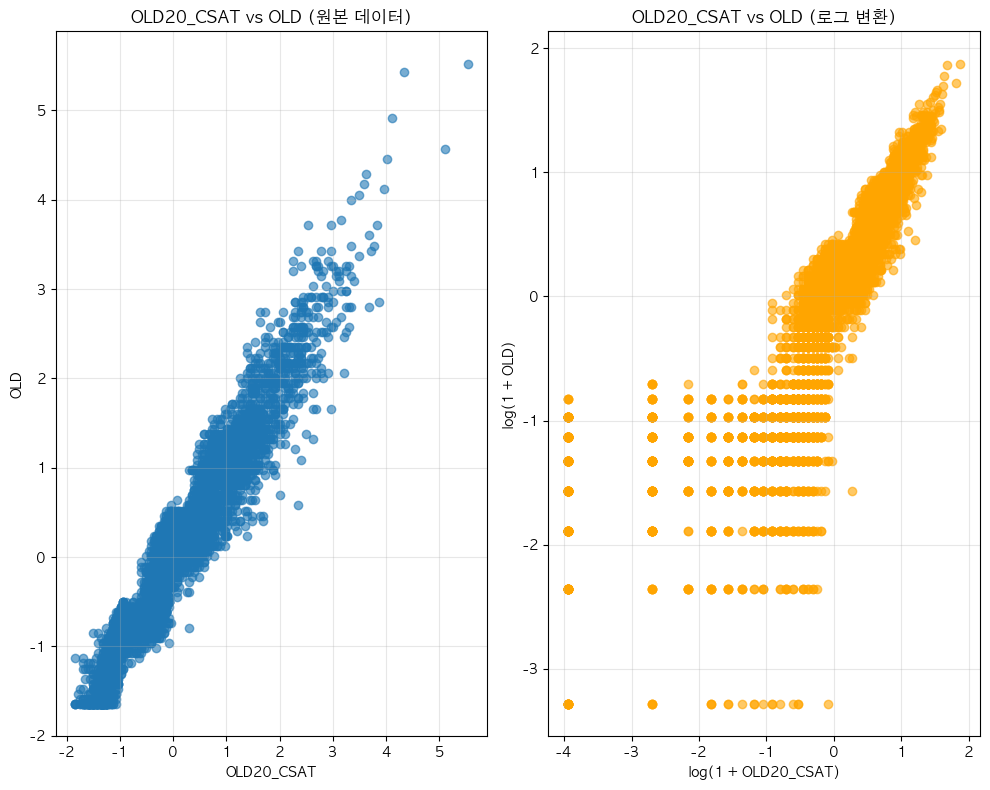

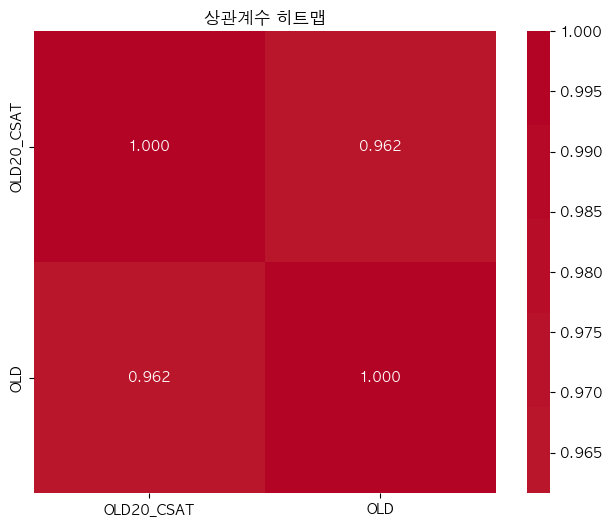

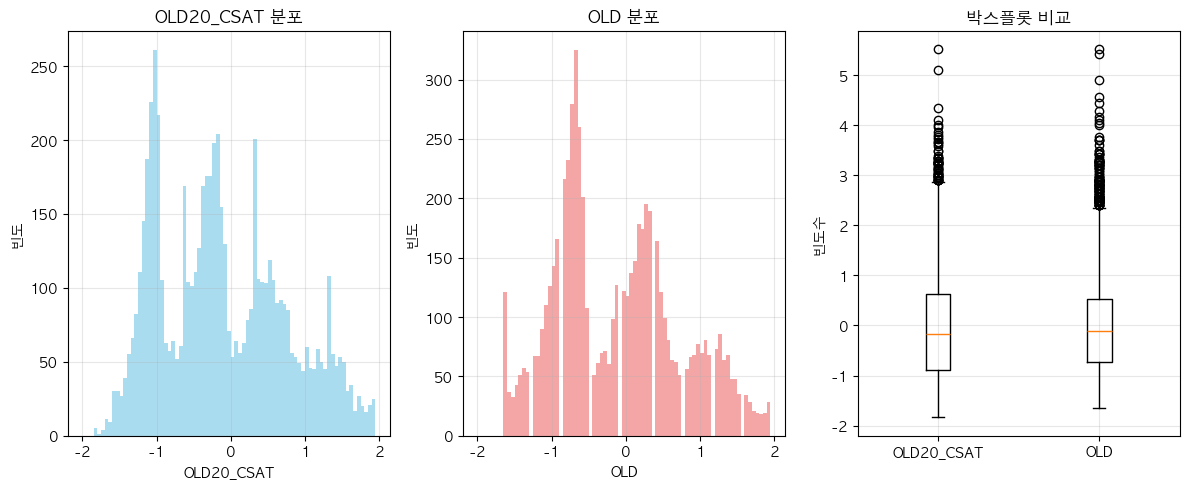

In [128]:
analyzer = analyze_word_frequency_correlation(df_CSAT_HAL, 'OLD20_CSAT', 'OLD', normalize=True, bins=np.arange(-2, 2, 0.05))

In [268]:
df_CSAT_HAL

,Word,Freq_CSAT,Freq_CSAT_relative,LogE_Freq_CSAT,Log10_Freq_CSAT,Freq_HAL,Log_Freq_HAL,POS
0,the,3149,0.003149,8.054840,3.498311,23099033,16.955,minor
1,to,1881,0.001881,7.539559,3.274620,12661276,16.354,minor
2,of,1561,0.001561,7.353082,3.193681,11003606,16.214,minor
3,and,1493,0.001493,7.308543,3.174351,10715411,16.187,minor
4,a,1284,0.001284,7.157735,3.108903,10610626,16.177,minor|NN
...,...,...,...,...,...,...,...,...
6619,fungi,1,0.000001,0.000000,0.301030,1169,7.064,NN
6620,matches,1,0.000001,0.000000,0.301030,12402,9.426,VB|NN
6621,integrative,1,0.000001,0.000000,0.301030,193,5.263,JJ
6622,agreements,1,0.000001,0.000000,0.301030,4919,8.501,NN


단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6570
SUBTLWF - 평균: 0.00, 표준편차: 1.00
Freq_CSAT_relative - 평균: 0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.8266 (p-value: 0.0000)
스피어만 상관계수: 0.6052 (p-value: 0.0000)
켄달 타우: 0.4700 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


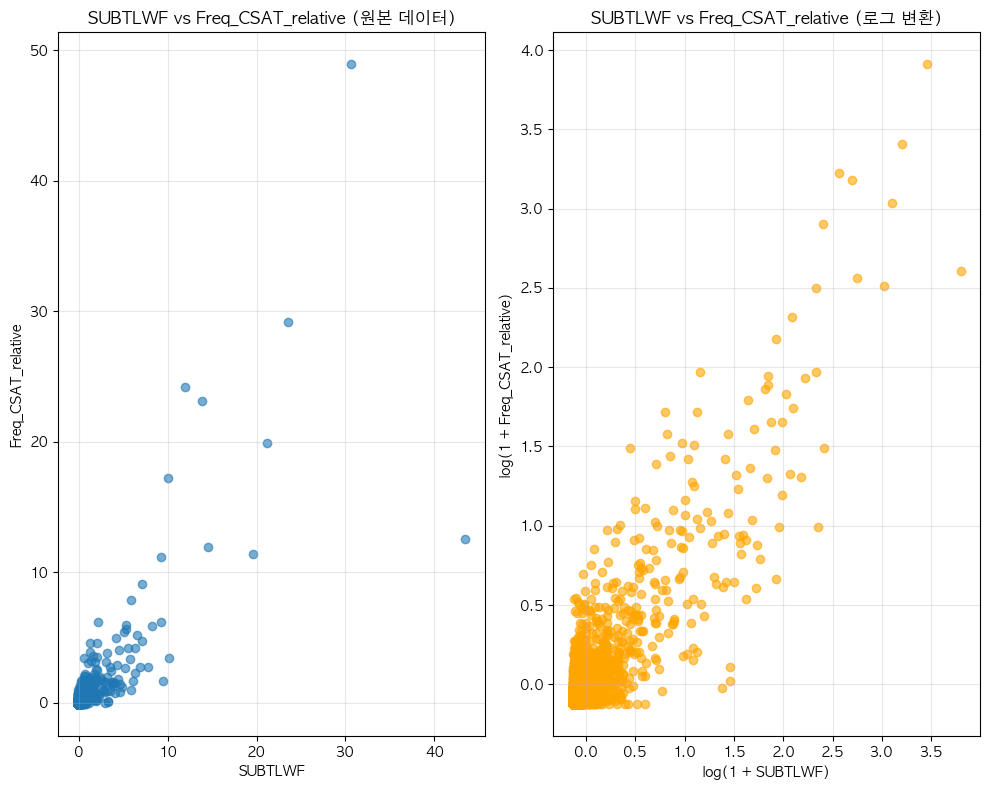

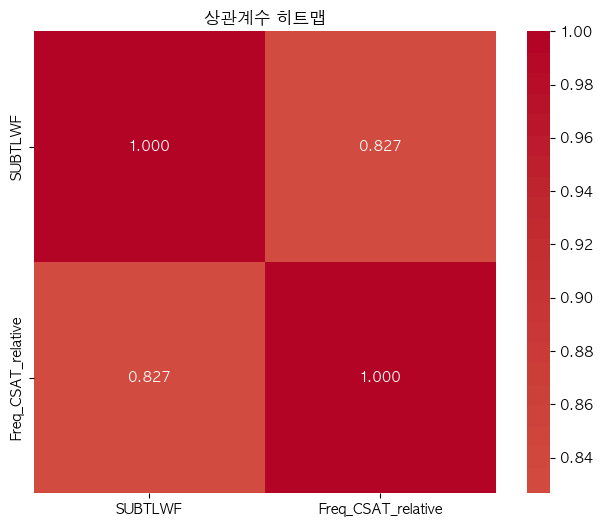

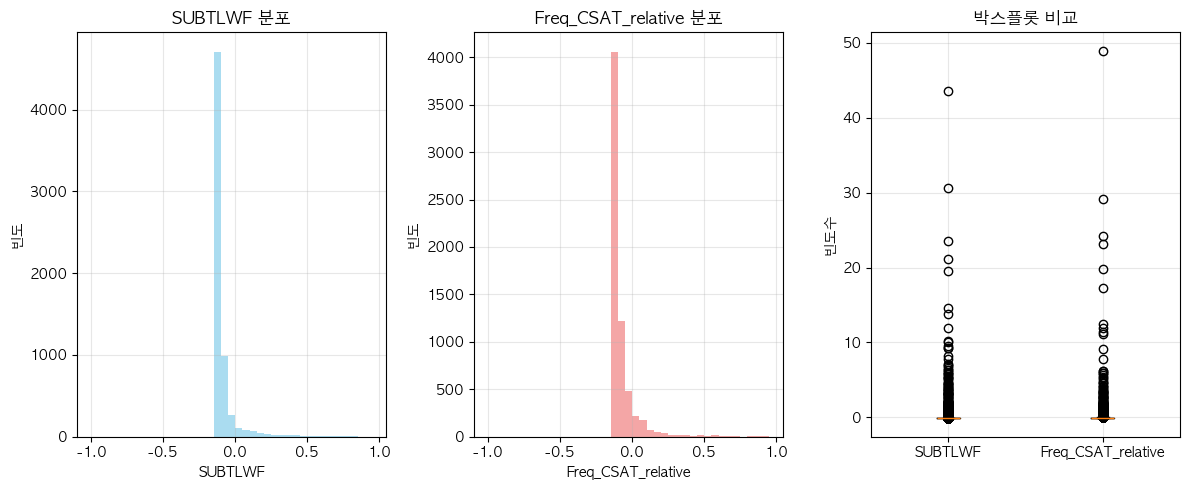

In [271]:
analyzer = analyze_word_frequency_correlation(df_CSAT_SUBTL, 'SUBTLWF', 'Freq_CSAT_relative', normalize=True, bins=np.arange(-1, 1, 0.05))

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 2972
SUBTLWF - 평균: 0.00, 표준편차: 1.00
Freq_CSAT_relative - 평균: -0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.7648 (p-value: 0.0000)
스피어만 상관계수: 0.5073 (p-value: 0.0000)
켄달 타우: 0.3910 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 강한 양의 상관관계


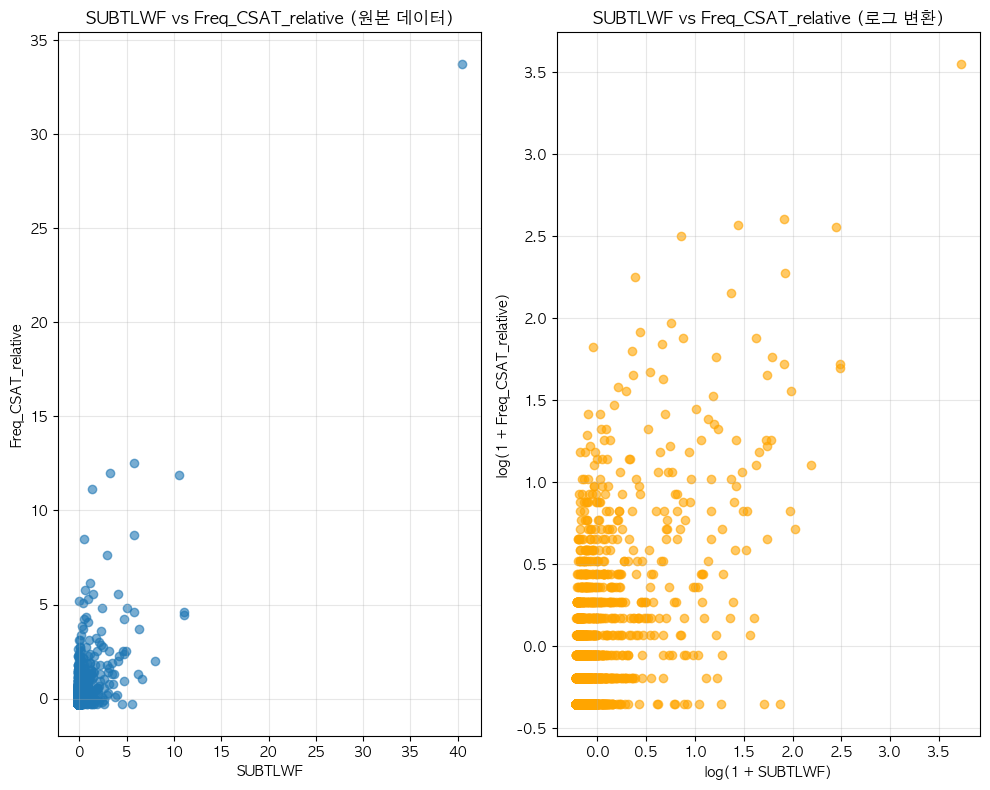

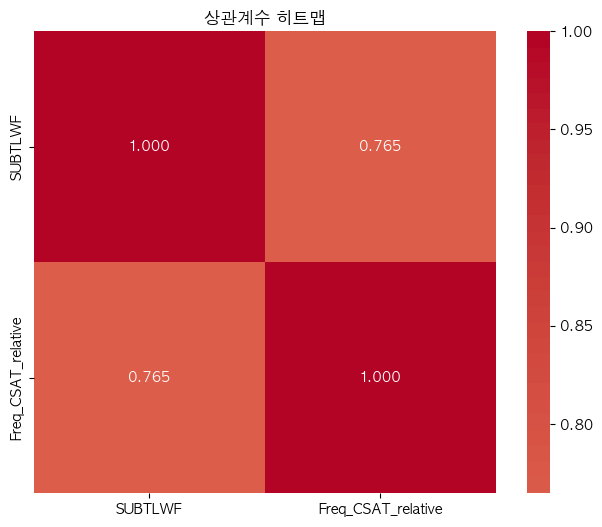

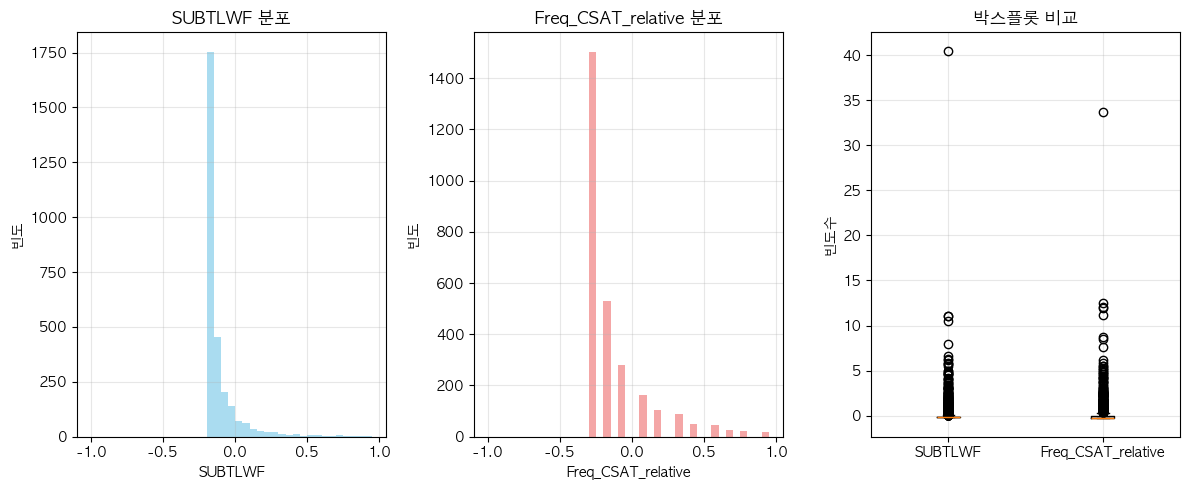

In [179]:
analyzer = analyze_word_frequency_correlation(df_CSAT_SUBTL, 'SUBTLWF', 'Freq_CSAT_relative', normalize=True, bins=np.arange(-1, 1, 0.05))

In [180]:
analyzer = analyze_word_frequency_correlation(new_df, 'Freq_CSAT_relative', 'Freq_HAL', normalize=True, bins=np.arange(-1, 1, 0.05))

KeyError: "['Freq_HAL'] not in index"

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6592
LogE_Freq_CSAT - 평균: 0.00, 표준편차: 1.00
Log_Freq_HAL - 평균: -0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.7313 (p-value: 0.0000)
스피어만 상관계수: 0.6898 (p-value: 0.0000)
켄달 타우: 0.5481 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 강한 양의 상관관계


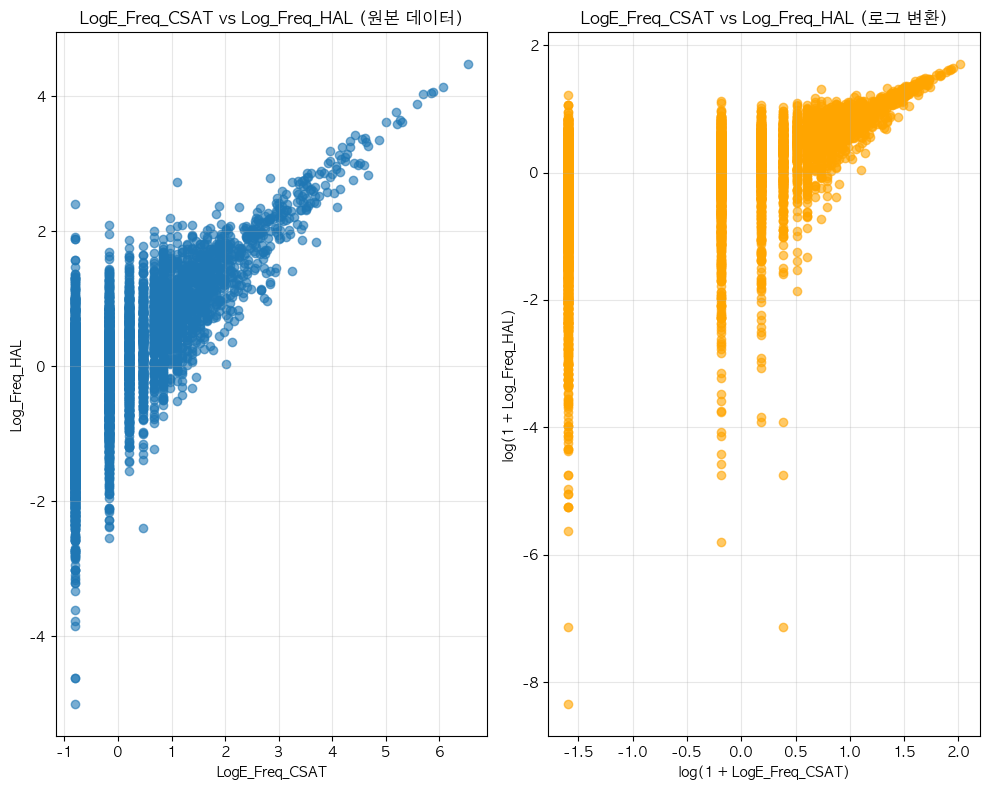

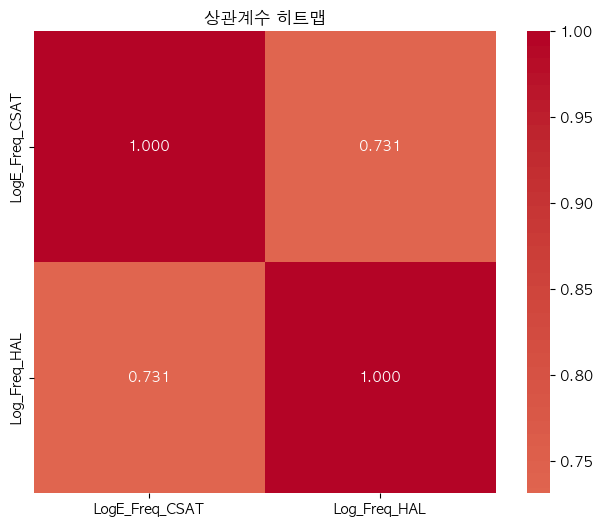

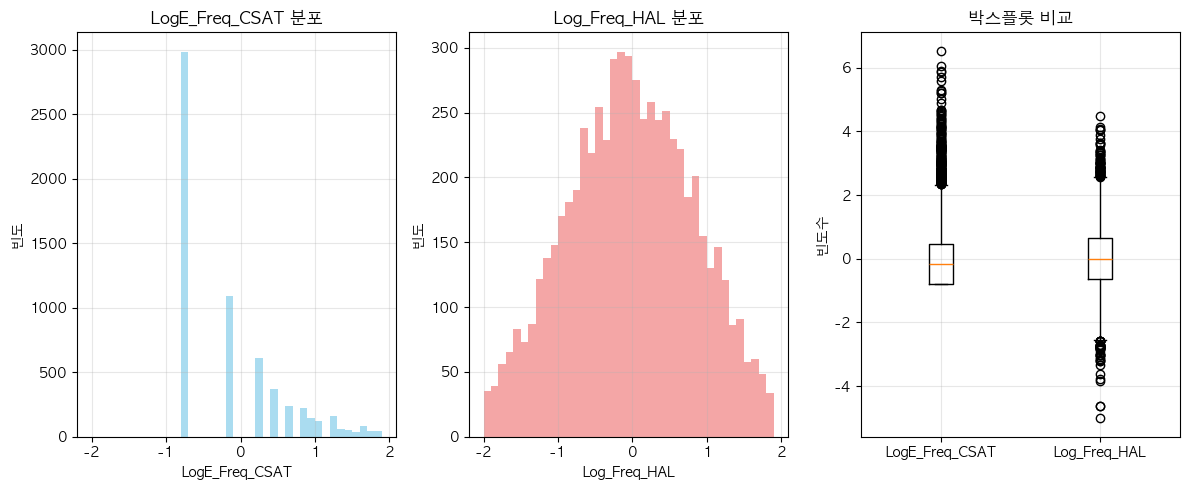

In [384]:
analyzer = analyze_word_frequency_correlation(new_df, 'LogE_Freq_CSAT', 'Log_Freq_HAL', normalize=True, bins=np.arange(-2, 2, 0.1))

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6571
Freq_CSAT - 평균: 0.00, 표준편차: 1.00
SUBTLWF - 평균: 0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.8272 (p-value: 0.0000)
스피어만 상관계수: 0.6056 (p-value: 0.0000)
켄달 타우: 0.4703 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


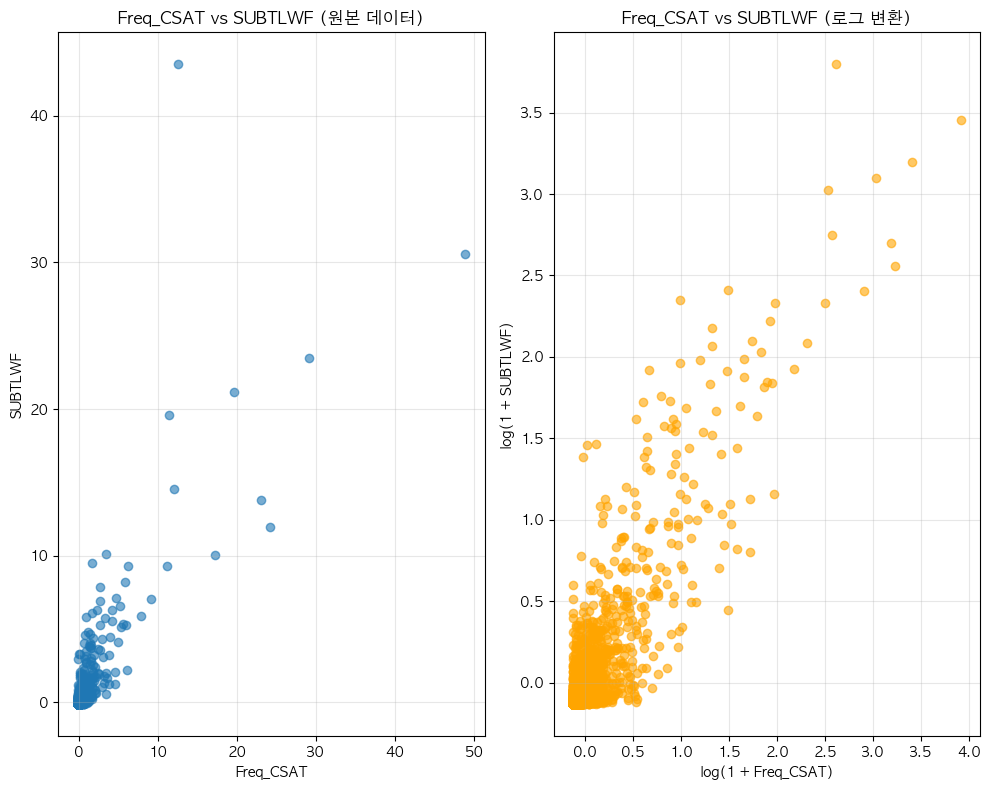

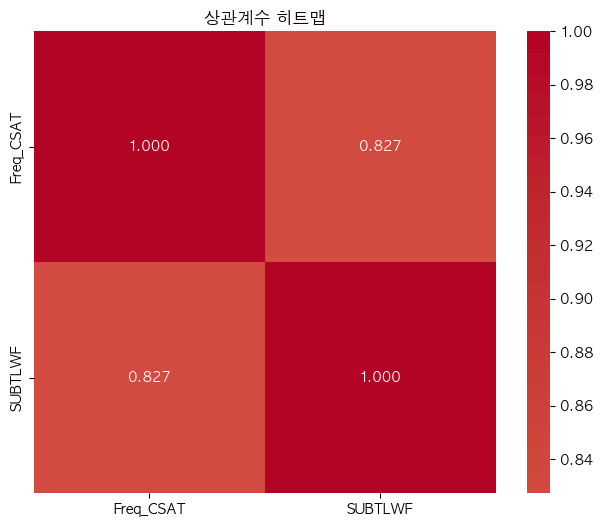

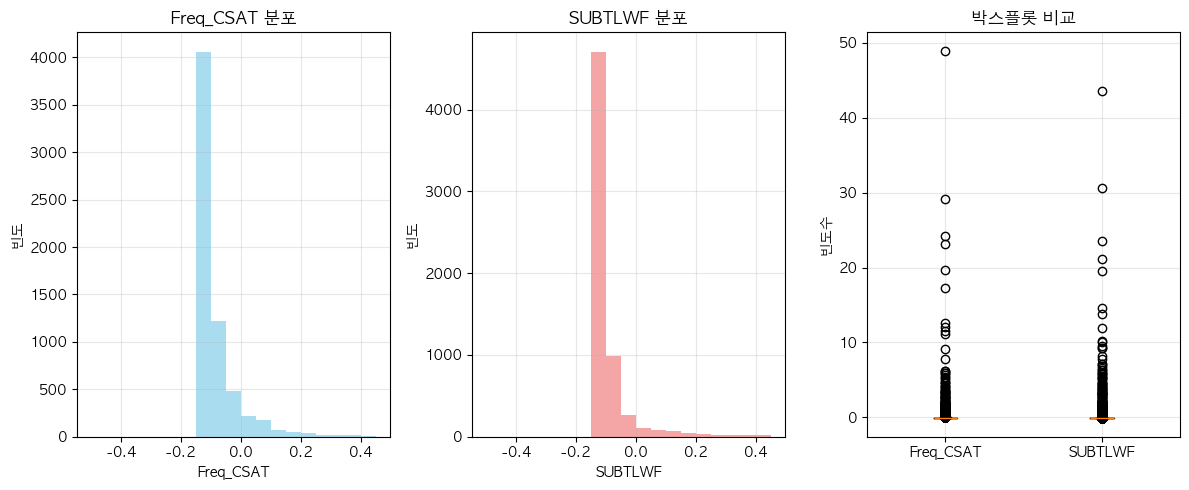

In [385]:
analyzer = analyze_word_frequency_correlation(new_df, 'Freq_CSAT', 'SUBTLWF', normalize=True, bins=np.arange(-0.5, 0.5, 0.05))

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6592
Ortho_N - 평균: -0.00, 표준편차: 1.00
Orthographic_N_CSAT - 평균: 0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.8706 (p-value: 0.0000)
스피어만 상관계수: 0.7876 (p-value: 0.0000)
켄달 타우: 0.7237 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


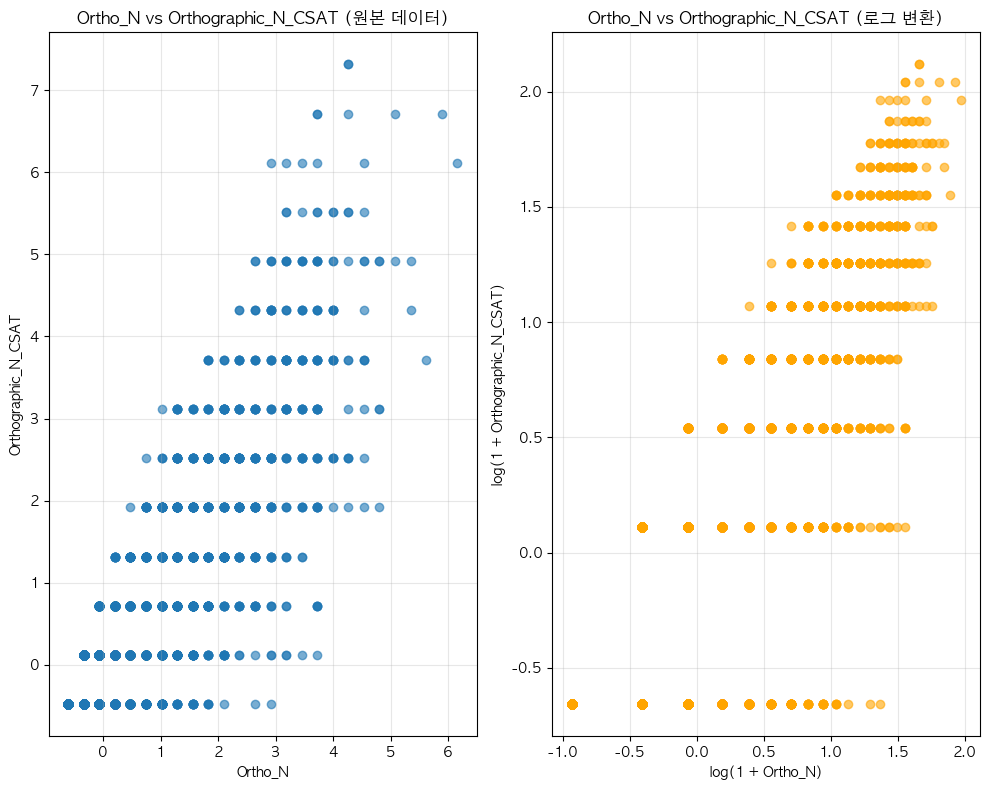

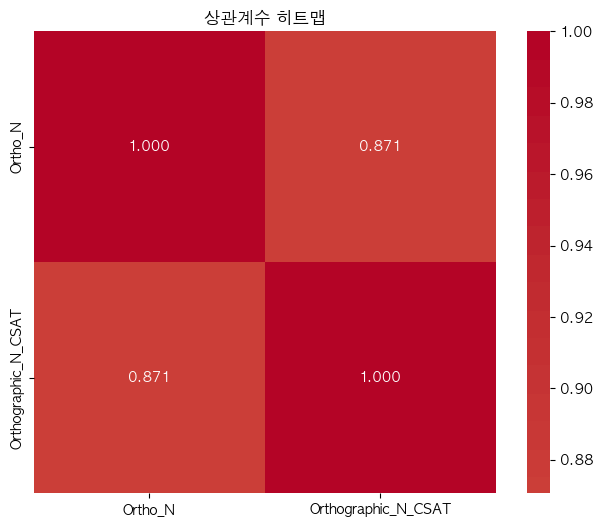

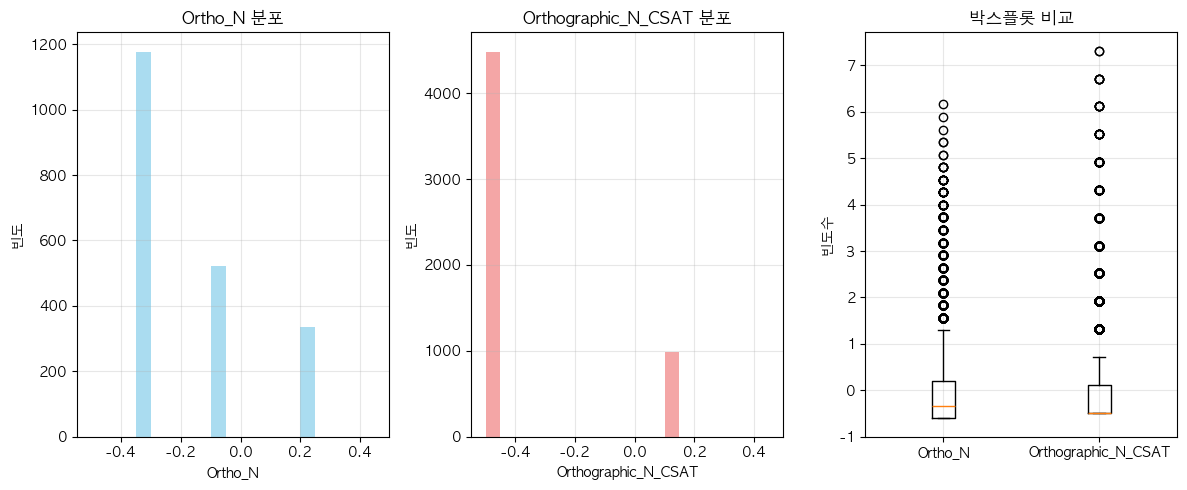

In [394]:
analyzer = analyze_word_frequency_correlation(new_df, 'Ortho_N', 'Orthographic_N_CSAT', normalize=True, bins=np.arange(-0.5, 0.5, 0.05))

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6592
OLD - 평균: -0.00, 표준편차: 1.00
OLD20_CSAT - 평균: 0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.9615 (p-value: 0.0000)
스피어만 상관계수: 0.9647 (p-value: 0.0000)
켄달 타우: 0.8508 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


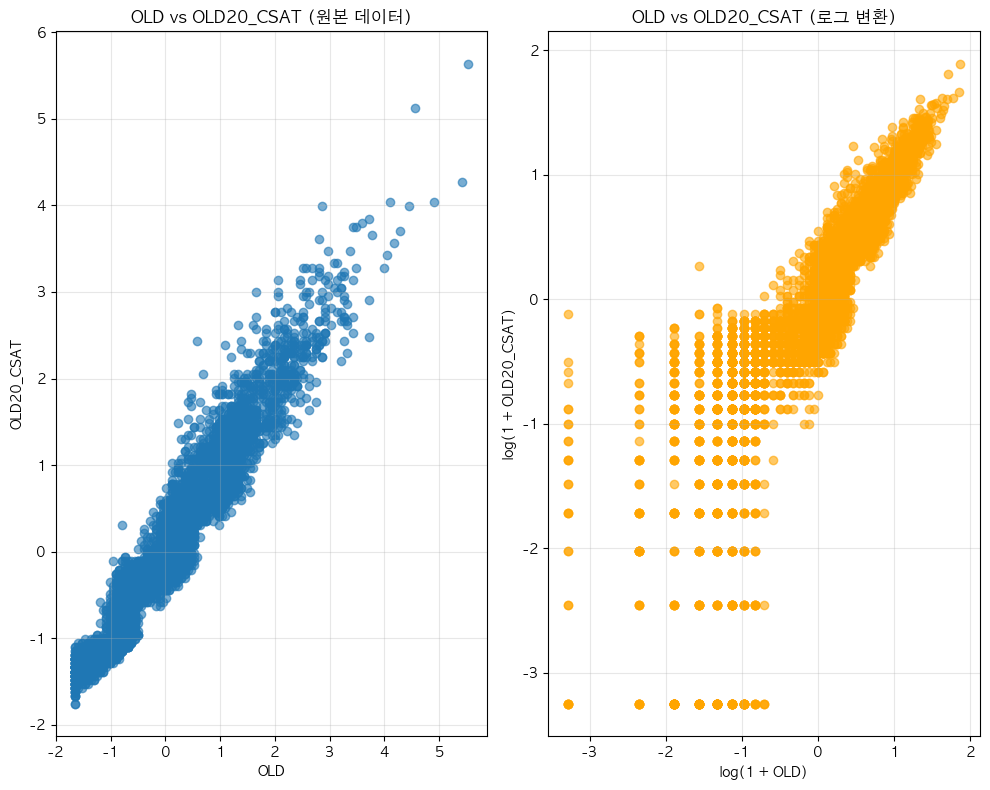

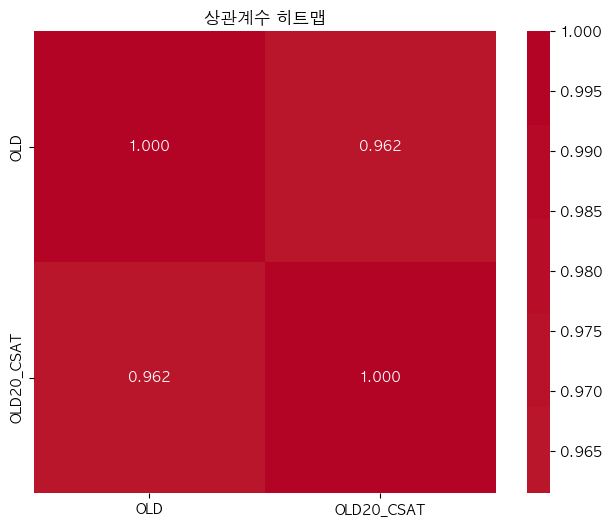

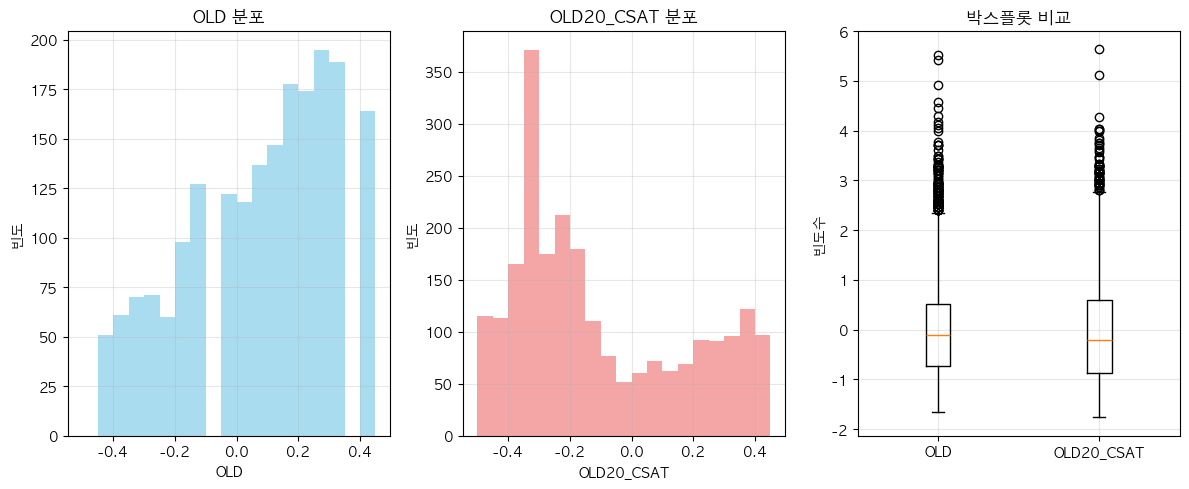

In [395]:
analyzer = analyze_word_frequency_correlation(new_df, 'OLD', 'OLD20_CSAT', normalize=True, bins=np.arange(-0.5, 0.5, 0.05))

# Levenshtein distance

In [83]:
# CSAT Corpus 내의 단어들을 lexicon 취급
lexicon = df['Word'].values

In [81]:
from Levenshtein import distance # distance measure function import

def orthographic_N(word : str, lexicon : list[str]) -> int: # orthographic N의 정의를 이용해서 이웃의 개수 산출.
    # 길이는 고정해두었기 때문에, levenshtein에서 허용하는 건 치환만. 또한, distance=1으로, 스스로는 제외
    return sum(1 for w in lexicon if len(w)==len(word) and distance(w, word)==1) 

def OLD20(word : str, lexicon : list[str]) -> float:
    dists = sorted(distance(word, w) for w in lexicon)[:20]
    return np.mean(dists).item()

In [390]:
new_df['Orthographic_N_CSAT'] = new_df['Word'].apply(lambda x: orthographic_N(x, lexicon))
new_df['OLD20_CSAT'] = new_df['Word'].apply(lambda x: OLD20(x, lexicon))

In [84]:
df['Orthographic_N_CSAT'] = df['Word'].apply(lambda x: orthographic_N(x, lexicon))
df['OLD20_CSAT'] = df['Word'].apply(lambda x: OLD20(x, lexicon))
df

,Word,Freq_CSAT,Freq_CSAT_relative,LogE_Freq_CSAT,Log10_Freq_CSAT,Orthographic_N_CSAT,OLD20_CSAT
0,.,3941,0.003941,8.279190,3.595717,24,0.95
1,",",3185,0.003185,8.066208,3.503246,24,0.95
2,the,3149,0.003149,8.054840,3.498311,1,1.55
3,to,1881,0.001881,7.539559,3.274620,9,1.10
4,of,1561,0.001561,7.353082,3.193681,6,1.45
...,...,...,...,...,...,...,...
7791,integrative,1,0.000001,0.000000,0.301030,0,4.10
7792,agreements,1,0.000001,0.000000,0.301030,0,3.85
7793,ellen,1,0.000001,0.000000,0.301030,1,2.40
7794,danielle,1,0.000001,0.000000,0.301030,0,3.60


In [85]:
df.to_csv('./corpus/csat_df_levenshtien.csv', index=False)

In [391]:
new_df.columns

Index(['Word', 'Freq_CSAT', 'LogE_Freq_CSAT', 'Log10_Freq_CSAT', 'Length',
       'Freq_HAL', 'Log_Freq_HAL', 'SUBTLWF', 'LgSUBTLWF', 'Ortho_N', 'OLD',
       'OLDF', 'Orthographic_N_CSAT', 'OLD20_CSAT'],
      dtype='object')

In [392]:
reindex_order = ['Word', 'Length', 'Freq_CSAT', 'LogE_Freq_CSAT', 'Log10_Freq_CSAT', 'Orthographic_N_CSAT', 'OLD20_CSAT', 
       'Freq_HAL', 'Log_Freq_HAL', 'SUBTLWF', 'LgSUBTLWF', 'Ortho_N', 'OLD',
       'OLDF']

new_df = new_df.reindex(columns=reindex_order)

In [393]:
new_df.to_excel('./corpus/merged_corpus.xlsx', index=False)